# <span style="color:#F72585"><center>Taller de Computación Bayesiana</center></span>


## <span style="color:#4361EE">Modelo Binomial</span>


### <span style="color:#4CC9F0">El problema</span>


Vamos a generar una observación Binomial. Para ello primero generamos un parámetro $\mu$ a partir de una distribución Beta. Usaremos los hiperparámetros $\alpha=5$ y $\beta=2$. Capricho de los autores. Vamos

In [2]:
# Import librerias
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# genera una semilla de los números aleatorios para hacer rpetible el ejercicio
np.random.seed(seed = 500) 

### <span style="color:#4CC9F0">Simula el parámetro $\mu$</span>


In [3]:
alpha = 5
beta = 2
mu = stats.beta(alpha,beta).rvs(1)

In [4]:
print("mu= ",mu)

mu=  [0.67330565]


Este es el parámetro de interés que intentaremos recuperar más adelante.


### <span style="color:#4CC9F0">Simula la observación aleatoria binomial $w$</span>


Vamos a suponer un experimento $\text{Binomial} (N,\mu)$, con $N= 100$.

In [5]:
N =100
w = stats.binom(n=N, p=mu).rvs(1)

In [6]:
print("w= ",w)

w=  [69]


### <span style="color:#4CC9F0">Cálculo de la posterior</span>


Vamos a suponer un apriori $\beta(1.2,1.2)$. NOs olvidamos de la distribución usada para generar $\mu$, puesto en la practica se desconoce.

Veamos un gráfico

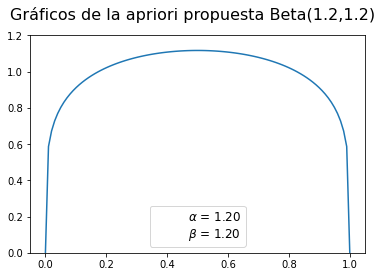

In [7]:
x = np.linspace(0,1,100)
y = stats.beta(1.2,1.2).pdf(x)

fig, ax = plt.subplots(1, 1,sharex = True, sharey = True, figsize=(6,4))
ax.set_ylim(0,1.2)
ax.plot(x,y)
ax.plot(0, 0, label="$\\alpha$ = {:3.2f}\n$\\beta$ = {:3.2f}".format(1.2, 1.2), alpha=0)
ax.legend(fontsize=12)
fig.suptitle('Gráficos de la apriori propuesta Beta(1.2,1.2)',fontsize=16)
plt.show()

Esta distribución es cercana a la uniforme $U(0,1)$. ¿Porque?

La distribución posterior es $\text{Beta}(1.2 +w, 1.2 + N-w)=\text{Beta}(70.2, 32.2)$

### <span style="color:#4CC9F0">Estimaciones</span>


#### <span style="color:#4CC9F0">Moda posterior</span>


In [8]:
from scipy.optimize import minimize_scalar as minimize

def f(t,alpha,beta):
    return  -stats.beta(alpha,beta).pdf(t)

lower = 1e-3
upper = 1  - 1e-3 
mode_f = minimize(f, bounds =(lower,upper),args=( 70.2,32.2), method='bounded' )

In [9]:
mode_f

     fun: -8.696851939248646
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 0.6892428669826581

In [10]:
MAP = mode_f.x

#### <span style="color:#4CC9F0">Mediana Posterior</span>


In [11]:
MEAP = stats.beta(70.2,32.2).ppf(0.5)
MEAP
# o también
stats.beta(70.2,32.2).median()

0.6867591043997296

#### <span style="color:#4CC9F0">Media Posterior</span>


In [12]:
EAP = stats.beta(alpha,beta).mean()
EAP

0.7142857142857143

#### <span style="color:#4CC9F0">Intervalo de credibilidad  del 95%</span>


In [13]:
i_cred_94 = stats.beta(70.2,32.2).ppf((0.03,0.97))
print("I.C. 94\%",i_cred_94)

I.C. 94\% [0.59676842 0.76818772]


#### <span style="color:#4CC9F0">Desviación estándar de la posterior</span>


In [14]:
desv= stats.beta(alpha,beta).std()
desv

0.15971914124998499

#### <span style="color:#4CC9F0">Resumen Estadístico de la distribución Posterior</span>


|Moda |Mediana | Media |Desv.|i_3%|i_97%|
|---|---|---|---|---|---|
|0.689|0.687|0.714|0.16|0.597|0.768|

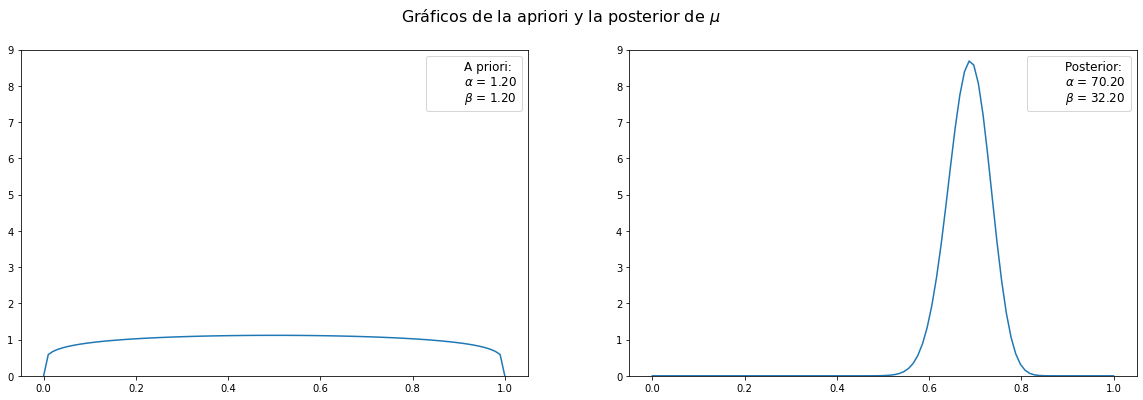

In [15]:
x = np.linspace(0,1,100)
y = stats.beta(1.2,1.2).pdf(x)

fig, ax = plt.subplots(1, 2,sharex = True, figsize=(20,6))
ax[0].set_ylim(0,9)
ax[0].plot(x,y)
ax[0].plot(0, 0, label="A priori: \n$\\alpha$ = {:3.2f}\n$\\beta$ = {:3.2f}".format(1.2, 1.2), alpha=0)
ax[0].legend(fontsize=12)

y = stats.beta(70.2,32.2).pdf(x)

ax[1].set_ylim(0,9)
ax[1].plot(x,y)
ax[1].plot(0, 0, label="Posterior: \n$\\alpha$ = {:3.2f}\n$\\beta$ = {:3.2f}".format(70.2, 32.2), alpha=0)
ax[1].legend(fontsize=12)
fig.suptitle('Gráficos de la apriori y la posterior de $\mu$',fontsize=16)
plt.show()

## <span style="color:#4361EE">Programación Probabilística</span>


In [16]:
# diccionario de datos

w=69
datos_binom = {'N': N,
               'w': w,
               'a': 1.2,
               'b': 1.2}

In [17]:
datos_binom

{'N': 100, 'w': 69, 'a': 1.2, 'b': 1.2}

````{tab} Pyro
```python
def binomial_code(N,w,a,b):
    mu = pyro.sample('mu', dist.Beta(a, b))
    with pyro.plate("plate"):
        pyro.sample("w",dist.Binomial(N,mu),obs=w)   
```
````
````{tab} TFP
```python
binomial_code = tfd.JointDistributionSequential([
  tfd.Beta(a, b, name="mu"),  # `mu` 
  lambda mu, N: (
      tfd.Independent(tfd.Binomial(N[..., tf.newaxis] , mu[..., tf.newaxis]),
                      name="w", 
                      reinterpreted_batch_ndims=1))
])

def target_log_prob_fn(mu):
  """Densidad objetivo no normalizada como función de estados."""
  return binomial_code.log_prob((N,mu))

```
````
````{tab} Stan
``` r
binomial_code = """
data {
    int<lower=0> N; // Tamaño del experiemnto
    int<lower=0,upper=N> w; // observacion binomial
    real<lower=0.0> a; // parámetros de la apriori: Beta(a,b)
    real<lower=0.0> b; 
}

parameters {
    real<lower=0.0001,upper=0.9999> mu;
}

model {
   mu ~ beta(a, b);
    w ~ binomial(N, mu);
}

generated quantities {
    real log_lik;
    int w_hat;
    log_lik = binomial_lpmf(w | N,mu);
    w_hat = binomial_rng(N, mu);
}
"""
```
````

### <span style="color:#4CC9F0">Compila el modelo</span>


````{tab} Pyro
```python
nuts_kernel = NUTS(binomial_code, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=300)
mcmc.run(J,y,sigma)
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(binomial_code, posterior_samples)(
    N,w,a,b
)
```
````

````{tab} TFP
```python
num_results = 5000
num_burnin_steps = 3000

# Mejorar el rendimiento rastreando el muestreador con `tf.function`
# y compilarlo usando XLA.
# autograph transforma un subconjunto de código de Python a TensorFlow
#jit_compile compila la función usando XLA
@tf.function(autograph=False, jit_compile=True)
def do_sampling():
    # Muestreador que usa cadenas de Markov
  return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      # Representación de nuestra previa
      current_state=[
          tf.zeros([J], name='init_mu'),
      ],
      kernel=tfp.mcmc.HamiltonianMonteCarlo(
          # Devuelve la log-densidad de nuestra previa
          target_log_prob_fn=target_log_prob_fn,
          step_size=0.4,
          num_leapfrog_steps=3))

states, kernel_results = do_sampling()

mu = states
sample_shape = [5000]

_, _, _, y = w.sample(
    value=(tf.broadcast_to(np.mean(mu, 0), sample_shape))
```
````

````{tab} Stan
``` r
# compile the  model
bm = pystan.StanModel(model_code=binomial_code)
```
````

### <span style="color:#4CC9F0">Extrae las muestras de la Posterior</span>


````{tab} Pyro
```python
samples=mcmc.get_samples()
```
````

````{tab} TFP
```python
samples = kernel_results
```
````

````{tab} Stan
``` r
# extract the samples
samples = bm.sampling(data=datos_binom, iter=6000, chains=4,warmup=1000,thin=5)
```
````

### <span style="color:#4CC9F0">Análisis Exploratorio Bayesiano</span>


````{tab} Arviz
```python
import arviz as az
import numpy as np
import pandas as pd
import xarray

```
````


````{tab} Pyro
```python
az.style.use('arviz-darkgrid')

xarray.set_options(display_style="html");

az_data = az.from_pyro(
    mcmc,
    posterior_predictive = posterior_predictive,
    }
)

```
````

````{tab} TFP
```python
az.style.use('arviz-darkgrid')

xarray.set_options(display_style="html");

az_data = az.from_tfp (
    posterior = kernel_results,
    posterior_predictive_samples=500,
    }
)
```
````

````{tab} Stan
``` r
az.style.use('arviz-darkgrid')

xarray.set_options(display_style="html");

    az_data = az.from_pystan(
    posterior=samples,
    posterior_predictive='w_hat',
    observed_data=['w'],
    log_likelihood={'w': 'log_lik'},
    )
```
````

````{tab} Arviz
```python
az.plot_density(az_data, var_names=['mu']);
```
````


````{tab} Pyro
```python
az.plot_autocorr(az_data, var_names=("mu"))
```
````


````{tab} Arviz
```python
az.plot_trace(az_data, var_names=("mu"))
```
````


````{tab} Arviz
```python
az.plot_mcse(az_data)
```
````


````{tab} Arviz
```python
az.summary(samples)
```
````


````{tab} Arviz
```python
az.plot_posterior(samples)
```
````
